In [1]:
# =========================================
# 1. librerías
# =========================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor # Modelo a optimizar
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import joblib

In [2]:
file_path = "C:/Users/jenif/Downloads/beisbol.csv"
try:
    datos = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: El archivo '{file_path}' no se encuentra en el directorio.")
    exit()


In [3]:
datos.head()

,Unnamed: 0,equipos,bateos,runs
0,0,Texas,5659,855
1,1,Boston,5710,875
2,2,Detroit,5563,787
3,3,Kansas,5672,730
4,4,St.,5532,762



Valores nulos por columna:
Unnamed: 0    0
equipos       0
bateos        0
runs          0
dtype: int64

Columnas numéricas detectadas: ['Unnamed: 0', 'bateos', 'runs']
Columnas categóricas detectadas: ['equipos']


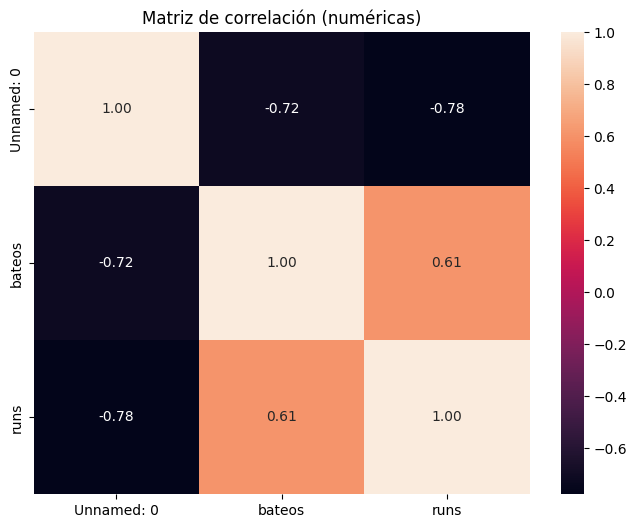

In [4]:
# =========================================
# 3. EDA rápido
# =========================================
print("\nValores nulos por columna:")
print(datos.isnull().sum())

numeric_cols = datos.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = datos.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nColumnas numéricas detectadas:", numeric_cols)
print("Columnas categóricas detectadas:", cat_cols)

# Matriz de correlación
if len(numeric_cols) >= 2:
    plt.figure(figsize=(8,6))
    sns.heatmap(datos[numeric_cols].corr(), annot=True, fmt='.2f')
    plt.title('Matriz de correlación (numéricas)')
    plt.show()



In [5]:
# =========================================
# 4. Selección de variable objetivo
# =========================================
target_column = 'bateos'
X = datos.drop(columns=[target_column])
y = datos[target_column]



In [6]:
# =========================================
# 5. Preprocesamiento
# =========================================
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])



In [7]:
# =========================================
# 6. Pipeline y optimización de hiperparámetros
# =========================================
# Definimos el modelo dentro del pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42)) # Se cambia a RandomForest
])

# Se definen los hiperparámetros a buscar
param_grid = {
    'model__n_estimators': [100, 200],  # Número de árboles en el bosque
    'model__max_depth': [10, 20, None], # Profundidad máxima de cada árbol
    'model__min_samples_split': [2, 5], # Número mínimo de muestras para dividir un nodo
    'model__min_samples_leaf': [1, 2],  # Número mínimo de muestras en un nodo hoja
}

# Se usa GridSearchCV para buscar la mejor combinación
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5, # Validación cruzada de 5-folds
    scoring='r2', # Métrica a optimizar (R2 score)
    n_jobs=-1, # Usar todos los núcleos de la CPU
    verbose=1
)



In [8]:
# =========================================
# 7. División train/test
# =========================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nTamaños train/test:", X_train.shape, X_test.shape)




Tamaños train/test: (24, 3) (6, 3)


In [9]:
# =========================================
# 8. Entrenamiento y Optimización
# =========================================
print("\nIniciando la búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("\n--- MEJORES HIPERPARÁMETROS ---")
print(grid_search.best_params_)



Iniciando la búsqueda de hiperparámetros...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

--- MEJORES HIPERPARÁMETROS ---
{'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}



--- MÉTRICAS EN TEST (MODELO OPTIMIZADO) ---
MAE:  48.8300
RMSE: 61.6506
R2:   -0.4564


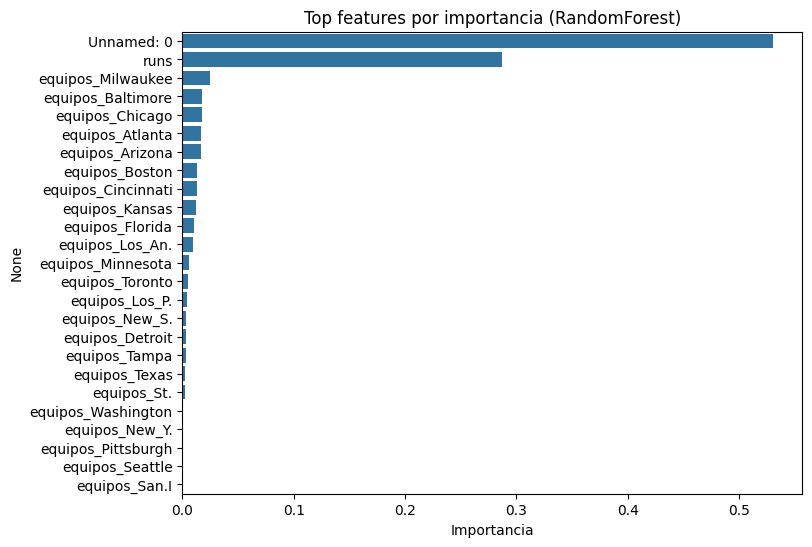

In [10]:
# =========================================
# 9. Evaluación
# =========================================
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- MÉTRICAS EN TEST (MODELO OPTIMIZADO) ---")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2:   {r2:.4f}")
# ---------------------------
# Importancia de características
# ---------------------------
try:
    # obtener nombres de features transformados
    pre = best_model.named_steps['preprocessor']
    num_cols = numeric_features
    cat_cols_trans = []
    if len(categorical_features) > 0:
        ohe = pre.named_transformers_['cat'].named_steps['onehot']
        cat_names = ohe.get_feature_names_out(categorical_features)
        cat_cols_trans = list(cat_names)
    feature_names = num_cols + cat_cols_trans

    rf = best_model.named_steps['model']
    importances = rf.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
    plt.figure(figsize=(8,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title('Top features por importancia (RandomForest)')
    plt.xlabel('Importancia')
    plt.show()
except Exception as e:
    print("No fue posible mostrar importancias de forma automática:", e)



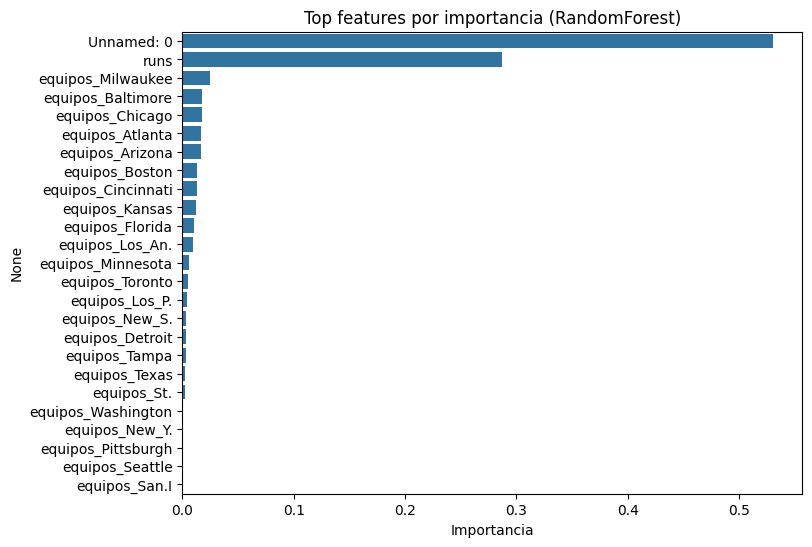

In [11]:
# ---------------------------
# Importancia de características (si aplica)
# ---------------------------
# Para obtener importancias, necesitamos obtener los nombres de columnas después del preprocesamiento.
try:
    # obtener nombres de features transformados
    pre = best_model.named_steps['preprocessor']
    # nombres numéricos
    num_cols = numeric_features
    # nombres categóricos transformados (onehot)
    cat_cols_trans = []
    if len(categorical_features) > 0:
        ohe = pre.named_transformers_['cat'].named_steps['onehot']
        cat_names = ohe.get_feature_names_out(categorical_features)
        cat_cols_trans = list(cat_names)
    feature_names = num_cols + cat_cols_trans

    rf = best_model.named_steps['model']
    importances = rf.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
    plt.figure(figsize=(8,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title('Top features por importancia (RandomForest)')
    plt.xlabel('Importancia')
    plt.show()
except Exception as e:
    print("No fue posible mostrar importancias de forma automática:", e)


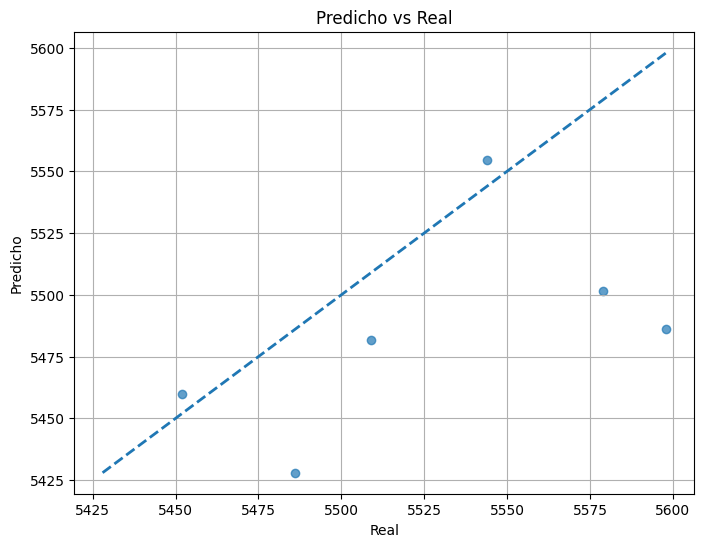

In [12]:
# =========================================
# 10. Gráficas
# =========================================
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', linewidth=2)
plt.xlabel('Real')
plt.ylabel('Predicho')
plt.title('Predicho vs Real')
plt.grid(True)
plt.show()


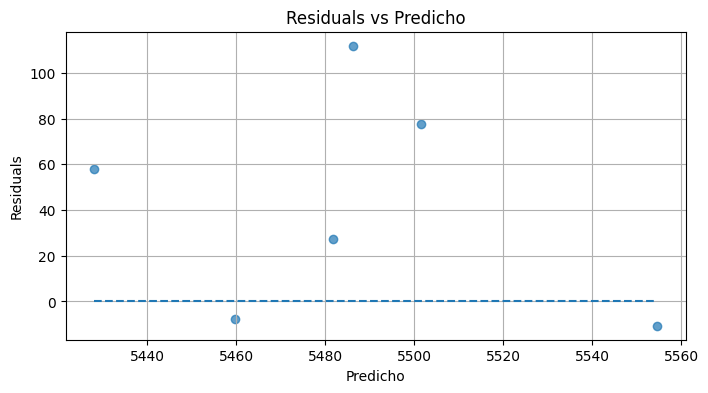

In [13]:

# Residuos
residuals = y_test - y_pred
plt.figure(figsize=(8,4))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.hlines(0, xmin=min(y_pred), xmax=max(y_pred), linestyles='--')
plt.xlabel('Predicho')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicho')
plt.grid(True)
plt.show()

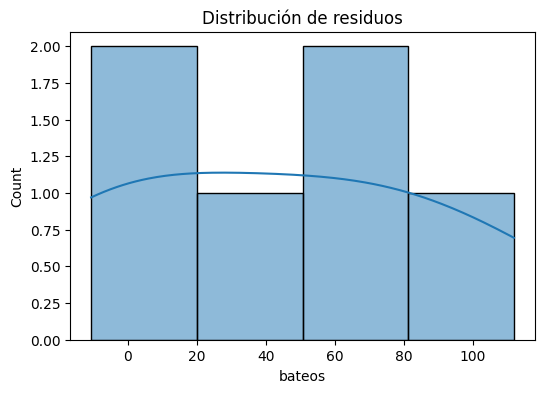

In [14]:
# Histograma de residuos
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title('Distribución de residuos')
plt.show()


In [15]:
# =========================================
# 11. Guardar modelo
# =========================================
os.makedirs('model', exist_ok=True)
model_path = os.path.join('model', 'linear_regression_beisbol.pkl')
joblib.dump(pipeline, model_path)
print("\nModelo guardado en:", model_path)


Modelo guardado en: model\linear_regression_beisbol.pkl
